## Fig.1c-f.See Fig.1b for GPS data download. Seismicity catalogue and InSAR dispalcement timeseries for a selected point are on the github page

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import datetime
import pandas as pd
import matplotlib.dates as mdates
import time
from datetime import datetime as dt
from IPython.core.debugger import set_trace

## Functions to read GPS data from file and reference it to 'MKEA' station

In [24]:
def read_ref_data(time1,time2):
    filename='./data/'+'MKEA.txt'
    dfin = pd.read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']
    dataval=pd.DataFrame(index=index)
    dataerr=pd.DataFrame(index=index);
    dataval=pd.concat([dfin['YYMMMDD'].rename('date'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                       (dfin['u0(m)']+dfin['____up(m)']).rename('up'),dfin['yyyy.yyyy'].rename('dateval')], axis=1)
    dataerr=pd.concat([dfin['YYMMMDD'].rename('date'), 
                       dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1,ignore_index=False)
    dataval['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    dataerr['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    time1 = pd.to_datetime(time1)
    time2 = pd.to_datetime(time2)
    mask= (dataval['date'] > time1) & (dataval['date'] < time2)
    dataval=dataval[mask];
    dataerr=dataerr[mask];
    dataval=dataval.set_index(['date'])
    dataval=dataval.resample('D').interpolate(method='linear')
    dataval=dataval.reset_index()
    return dataval

def read_data(sitename,time1,time2):
    filename='./data/'+sitename+'.txt'
    dfin = pd.read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']

    dataval=pd.DataFrame(index=index);dataerr=pd.DataFrame(index=index);
    dataval=pd.concat([dfin['YYMMMDD'].rename('date'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                       (dfin['u0(m)']+dfin['____up(m)']).rename('up'),dfin['yyyy.yyyy'].rename('dateval')], axis=1)
    dataerr=pd.concat([dfin['YYMMMDD'].rename('date'), dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1,ignore_index=False)
    dataval['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    dataerr['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    time1 = pd.to_datetime(time1)
    time2 = pd.to_datetime(time2)
    mask= (dataval['date'] > time1) & (dataval['date'] < time2)
    dataval=dataval[mask];dataerr=dataerr[mask];
    #reference to MKEA
    dataval2=read_ref_data(time1,time2)
    merged=pd.merge(dataval,dataval2,how='inner',on=['date'])
    merged['east']=merged['east_x']-merged['east_y'];
    merged['north']=merged['north_x']-merged['north_y'];
    merged['up']=merged['up_x']-merged['up_y'];
    merged['dateval']=(merged['dateval_x']+merged['dateval_y'])*0.5
    merged=merged[['date','east','north','up','dateval']]
    return merged


In [25]:
years = mdates.YearLocator(1)   # every year
months = mdates.MonthLocator(interval=3)  # every month
yearsFmt = mdates.DateFormatter('%Y')

data = pd.read_csv('../eq_catalogs/eq_summit_2011_2020.csv',header=0, parse_dates=['time'],index_col='time')
data2=data.resample('M')['mag'].count().to_frame()
data = pd.read_csv('../eq_catalogs/eq_east_decollement_2011_2020.csv',header=0, parse_dates=['time'],index_col='time')
data3=data.resample('M')['mag'].count().to_frame()
data = pd.read_csv('../eq_catalogs/eq_west_decollement_2011_2020.csv',header=0, parse_dates=['time'],index_col='time')
data4=data.resample('M')['mag'].count().to_frame()
InSAR_ts = pd.read_csv('y1494_x1673_ts.txt',skiprows=6,header=None,delimiter=r"\s+",
                   names=['date','disp'],parse_dates=['date'])
InSAR_ts['date'] = [pd.to_datetime(d) for d in InSAR_ts['date']];

## Try with heading2 

In [26]:
# print(InSAR_ts)

## Plot figure

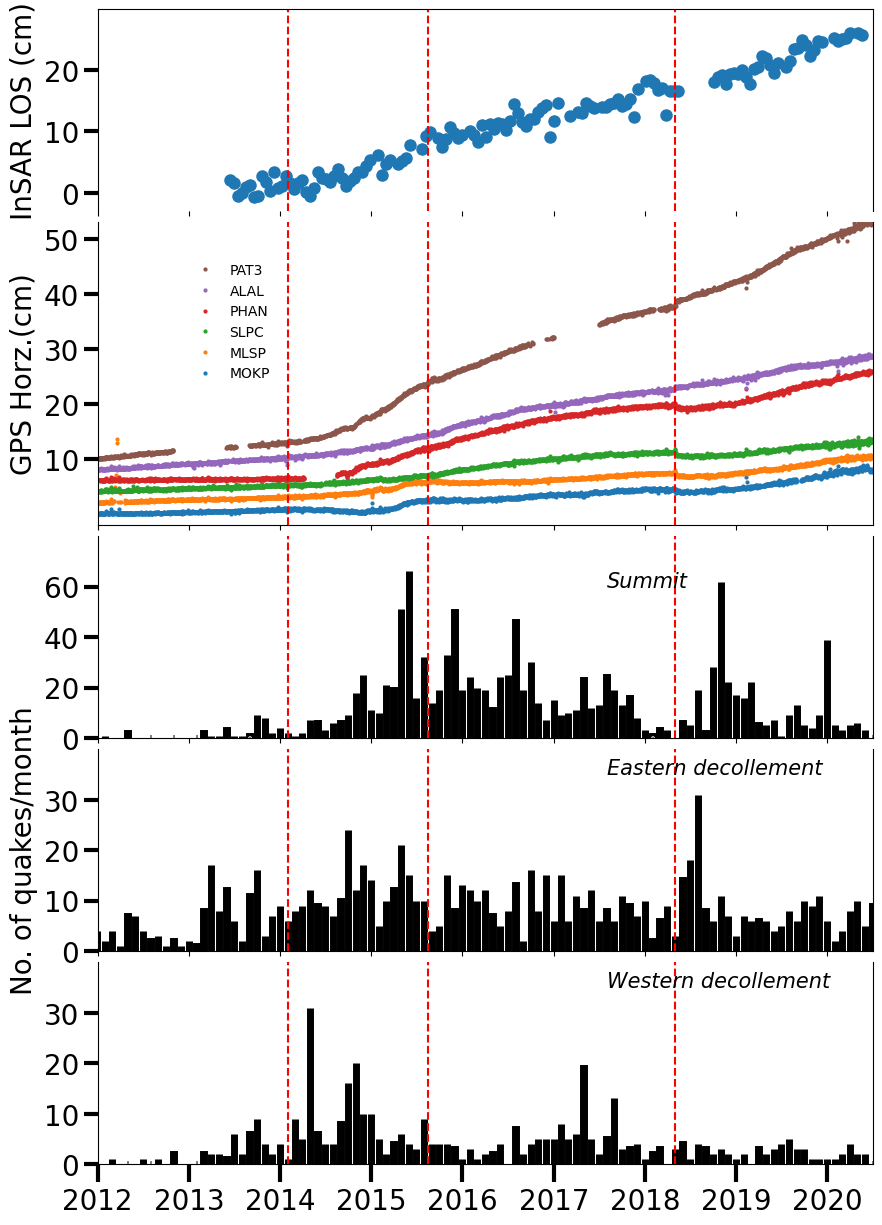

In [28]:
x=[datetime.date(2012, 1, 1), datetime.date(2020, 6, 30)]
y=[0,40];

fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True,figsize=(10, 15), gridspec_kw = {'height_ratios':[1,1.5,1,1,1]});

#customize axes
fig.subplots_adjust(hspace=0.05)
ff=20;ffti=20;
for i in range(5):
    axes[i].tick_params(labelsize=ff);
    axes[i].tick_params(axis='y',length=10, width=3);axes[i].tick_params(axis='y',length=10, width=3);
    axes[i].tick_params(which='minor',length=0, width=0);
    axes[i].xaxis.set_major_locator(years);
    axes[i].xaxis.set_major_formatter(yearsFmt) 
    if i>0:
        axes[i].spines['top'].set_color('none');
axes[0].spines['bottom'].set_color('none');    
axes[0].set_yticks([0,10,20]);axes[1].set_yticks([0,10,20,30]);
axes[4].set_xlim([x[0], x[-1]]);axes[4].set_yticks(np.arange(0, 80, 20));
axes[4].tick_params(axis='x',length=13, width=3);axes[4].tick_params(which='minor',length=7, width=2);

#plot InSAR timeseries data
axes[0].plot_date(InSAR_ts['date'],InSAR_ts['disp'],marker='o',label='InSAR',markersize=8.0);
axes[0].set_ylabel('InSAR LOS (cm)',fontsize=ffti)
axes[0].set_ylim([-3,30]);

#plot GPS timeseries
site_list=['MOKP','MLSP','SLPC','PHAN','ALAL','PAT3'];
time1=x[0];time2=x[1];t=0;
for site in site_list:
    gps_data=read_data(site,time1,time2);
    gps_data['up']=(gps_data['up']-gps_data['up'].iloc[0:10].mean())*100
    gps_data['north']=(gps_data['north']-gps_data['north'].iloc[0:10].mean())*100 #+t;t=t+15;
    gps_data['east']=(gps_data['east']-gps_data['east'].iloc[0:10].mean())*100 #+t; #t=t+15;
    gps_data['horz']=(gps_data['east']*gps_data['east']+gps_data['north']*gps_data['north'])**(0.5)+t; t=t+2;
    axes[1].plot_date(gps_data['date'],gps_data['horz'],marker='o',markersize=2.0,label=site);
axes[1].set_ylim([-2,53]);axes[1].set_yticks([10,20,30,40,50]);
axes[1].set_ylabel('GPS Horz.(cm)',fontsize=ffti);
lgnd=axes[1].legend(labelspacing=-2.5,fontsize=10,bbox_to_anchor=(0.31, 0.65), bbox_transform=plt.gcf().transFigure,frameon=False)
#for handle in lgnd.legendHandles:
#    handle._legmarker.set_markersize(6)

#Plot seismicity rate
axes[2].bar(data2.index,data2.mag,color='black',edgecolor='k',linewidth=5);
axes[3].bar(data3.index,data3.mag,color='black',edgecolor='k',linewidth=5);
axes[4].bar(data4.index,data4.mag,color='black',edgecolor='k',linewidth=5);

axes[2].set_ylim([0, 80]);axes[2].set_yticks(np.arange(0, 80, 20));
axes[3].set_ylim([0, 40]);axes[3].set_yticks(np.arange(0, 40, 10));
axes[4].set_ylim([0, 40]);axes[4].set_yticks(np.arange(0, 40, 10));

axes[3].set_ylabel('No. of quakes/month',fontsize=ffti);

vlines=[datetime.date(2014, 1, 31),datetime.date(2015, 8, 15),datetime.date(2018, 5, 1)];
for i in range(len(vlines)):
    for j in range(5):
        axes[j].axvline(vlines[i],color='r',linestyle='--');
marker=datetime.date(2017, 8, 1);
axes[2].text(marker, 60, 'Summit', fontsize=15,style='italic');
axes[3].text(marker, 35, 'Eastern decollement', fontsize=15,style='italic');
axes[4].text(marker, 35, 'Western decollement', fontsize=15,style='italic');

#save plot
#plt.savefig('Fig.1c-f_displacement_over_SeismicityRates.pdf',dpi=300,bbox_inches='tight',transparent=True)
